## Calcolo le riduzioni di flusso del segnale considerando un rapporto di 1 cm di stratificazione ogni 100 anni

In [1]:
from Halite import *
from paleopy import *

import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d

import paleopy as paleopy

halite = paleopy.Mineral("Halite")

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
name = ['100yr', '300yr', '1kyr', '3kyr', '10kyr', '30kyr', '100kyr', '300kyr'] #intestazioni durate dei flussi
arr_time = [200*1e-6, (650-200)*1e-6, (2000-650)*1e-6, (6500-2000)*1e-6, (0.02-0.0065), (0.065-0.02), (0.2-0.065), (0.27-0.2)] #tempi tra un flusso e l'altro
tot_time= 0.3 #in Myr

depths = [1e-5, 3e-5, 1e-4, 3e-4, 1e-3, 3e-3, 1e-2, 3e-2] #in km

/home/fefe/Thesis/all_you_need/geant/Halite.py:42: RuntimeWarning: divide by zero encountered in log10
  logy = np.log10(yy)
/home/fefe/Thesis/all_you_need/geant/Halite.py:42: RuntimeWarning: divide by zero encountered in log10
  logy = np.log10(yy)
/home/fefe/Thesis/all_you_need/geant/Halite.py:42: RuntimeWarning: divide by zero encountered in log10
  logy = np.log10(yy)


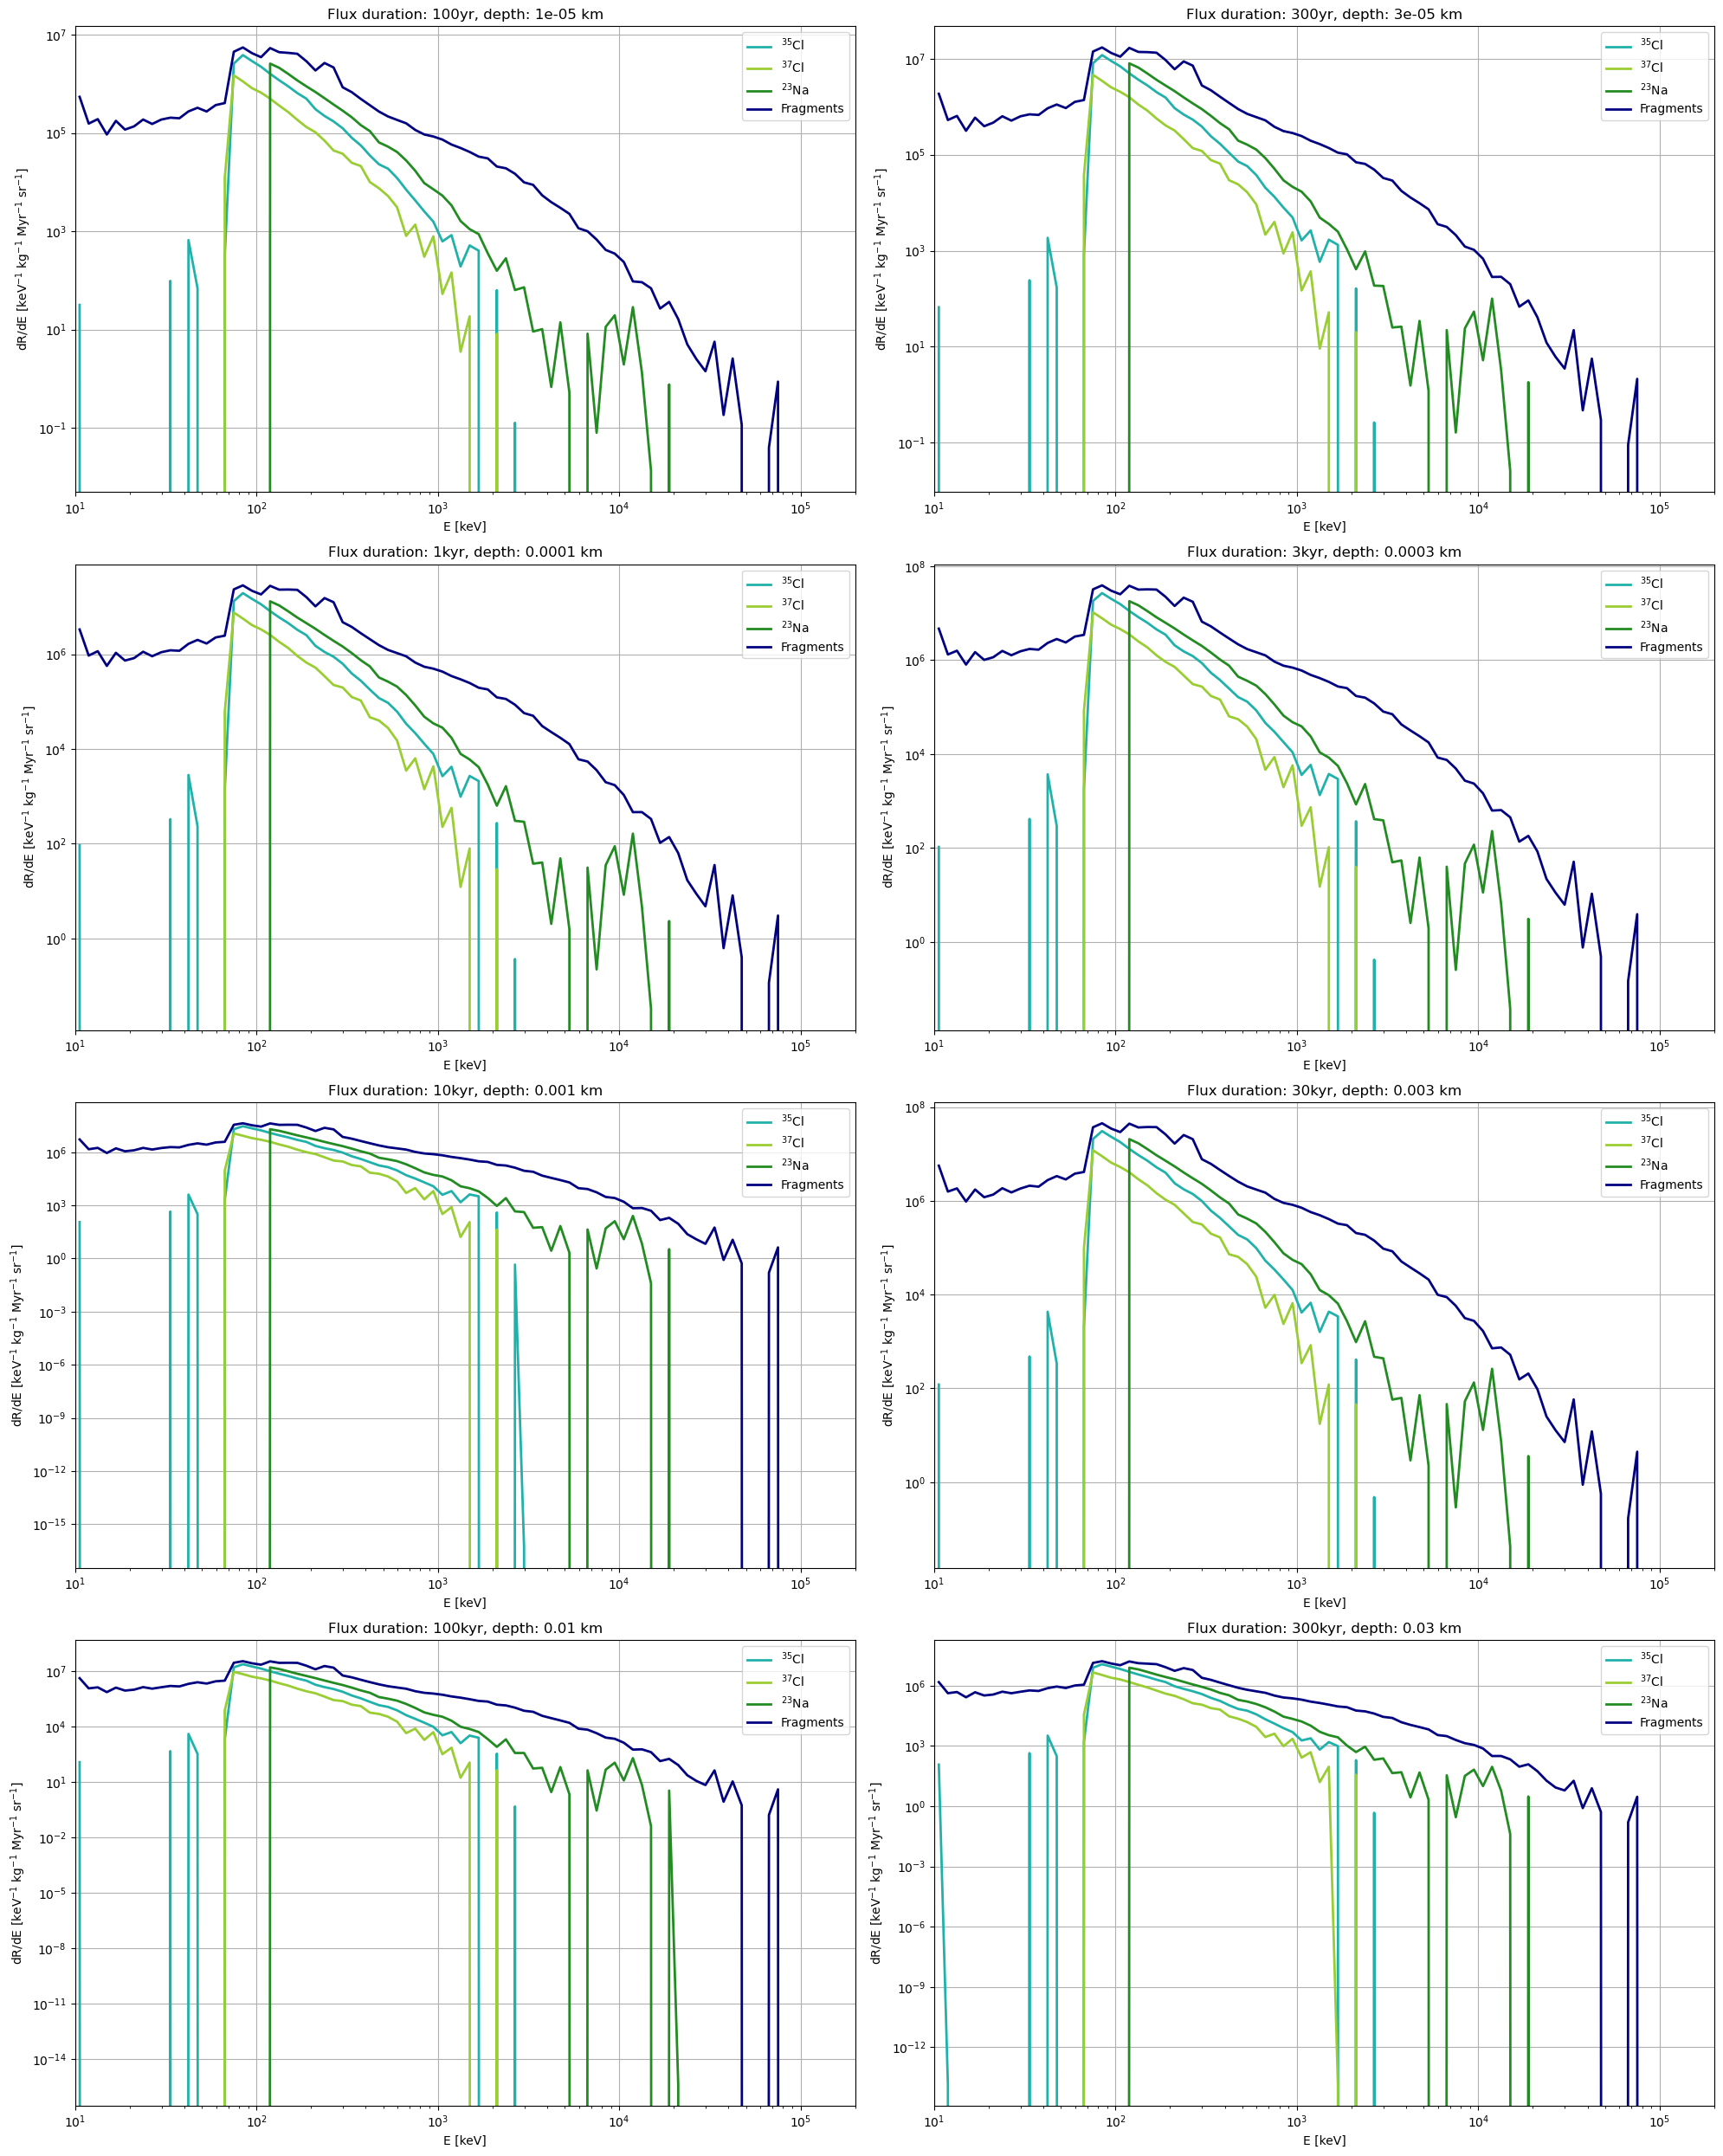

In [3]:
listfunc = []

# Prepara la figura con 8 subplot (4 righe x 2 colonne)
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20, 25))
axes = axes.flatten()  # per iterare comodamente in un unico array di subplot

for i, nm in enumerate(name):
    # Carica i dati dal file di testo per la durata di flusso 'nm'
    x, y = np.loadtxt('MuonFluxes/SN20pc' + nm + '.txt', usecols=(0, 1), unpack=True)
    # Calcolo differenziale dei flussi e asse x
    y = y[:-1] / np.diff(x)
    x = x[:-1]
    
    # Aggiunge a listfunc la funzione interpolata (log) del flusso
    listfunc.append(log_interp1d(x, 1e-4 * y))

    # Attenuazione del flusso dovuta alla profondità corrispondente
    # qui applichiamo di nuovo la correzione a TUTTE le funzioni in listfunc,
    # come nel tuo codice originale, ma potrebbe essere un comportamento da rivedere
    for j, _ in enumerate(listfunc):
        xx = np.logspace(-2, 3, 101)
        ee = par(depths[i]) * (xx + 510) - 510
        yy = listfunc[j](ee) * par(depths[i])
        listfunc[j] = log_interp1d(xx, yy)

    # Integra i flussi nel tempo
    Num = Integration(listfunc, arr_time, tot_time)
    weight = Num / 1e4  # perchè per integrare ho fatto 1e4 simulazioni

    # Definizione dei bin di energia
    n = 101
    Er = np.logspace(-2, 3, n)  # MeV da 1e-2 a 1e3 in 101 bin
    Er_width = np.diff(Er)
    Er_mid = Er[:-1] + Er_width/2  # centro di ciascun bin
    
    length = 1000  # cm
    rho = 2.16e-3  # kg/cm^3

    # Conta i nuclei prodotti (la funzione Count restituisce 5 array)
    Conta = Count(weight, Er)  # [Cl35, Cl37, Na23, Frag, nomiNuclei]
    
    # Somma dei frammenti (Frag) su tutti i nuclei secondari
    Frag = np.zeros(len(Er_mid))
    for k in range(len(Conta[4])):       # scorri tutti i 'nomi' dei nuclei
        for j_bin in range(len(Er_mid)): # scorri i bin energetici
            Frag[j_bin] += Conta[3][k][j_bin]

    # Interpola i conteggi normalizzati per ciascun nucleo
    F35 = interp1d(Er_mid, Conta[0] / Er_width, fill_value='extrapolate')
    F37 = interp1d(Er_mid, Conta[1] / Er_width, fill_value='extrapolate')
    F23 = interp1d(Er_mid, Conta[2] / Er_width, fill_value='extrapolate')

    # Seleziona il subplot corrente
    ax = axes[i]

    # Grafico in scala log-log
    ax.loglog(Er_mid * 1e3, F35(Er_mid) * 1e-3 / (length * rho), label="$^{35}$Cl", linewidth=2, color='lightseagreen')
    ax.loglog(Er_mid * 1e3, F37(Er_mid) * 1e-3 / (length * rho), label="$^{37}$Cl", linewidth=2, color='yellowgreen')
    ax.loglog(Er_mid * 1e3, F23(Er_mid) * 1e-3 / (length * rho), label="$^{23}$Na", linewidth=2, color='forestgreen')
    ax.loglog(Er_mid * 1e3, Frag * 1e-3 / Er_width / (length * rho), label="Fragments", linewidth=2, color='navy')

    ax.set_xlabel("E [keV]")
    ax.set_ylabel("dR/dE [keV$^{-1}$ kg$^{-1}$ Myr$^{-1}$ sr$^{-1}$]")
    ax.set_xlim(1e1, 2e5)
    ax.grid(True)
    ax.legend()

    # Titolo con durata e profondità
    ax.set_title(f"Flux duration: {nm}, depth: {depths[i]:.3g} km")

    # Salva i dati su file (la funzione Stampa dovrà essere definita/importata)
    Stampa('20pc_overburden_', nm, Conta, Er)

# Layout finale e salvataggio dell’immagine
plt.tight_layout()
plt.savefig("recoil_halite/plot/nuclear_recoil_20pc_all.png", bbox_inches="tight")
plt.show()


## Attenuazione del background

/home/fefe/Thesis/all_you_need/geant/Halite.py:42: RuntimeWarning: divide by zero encountered in log10
  logy = np.log10(yy)


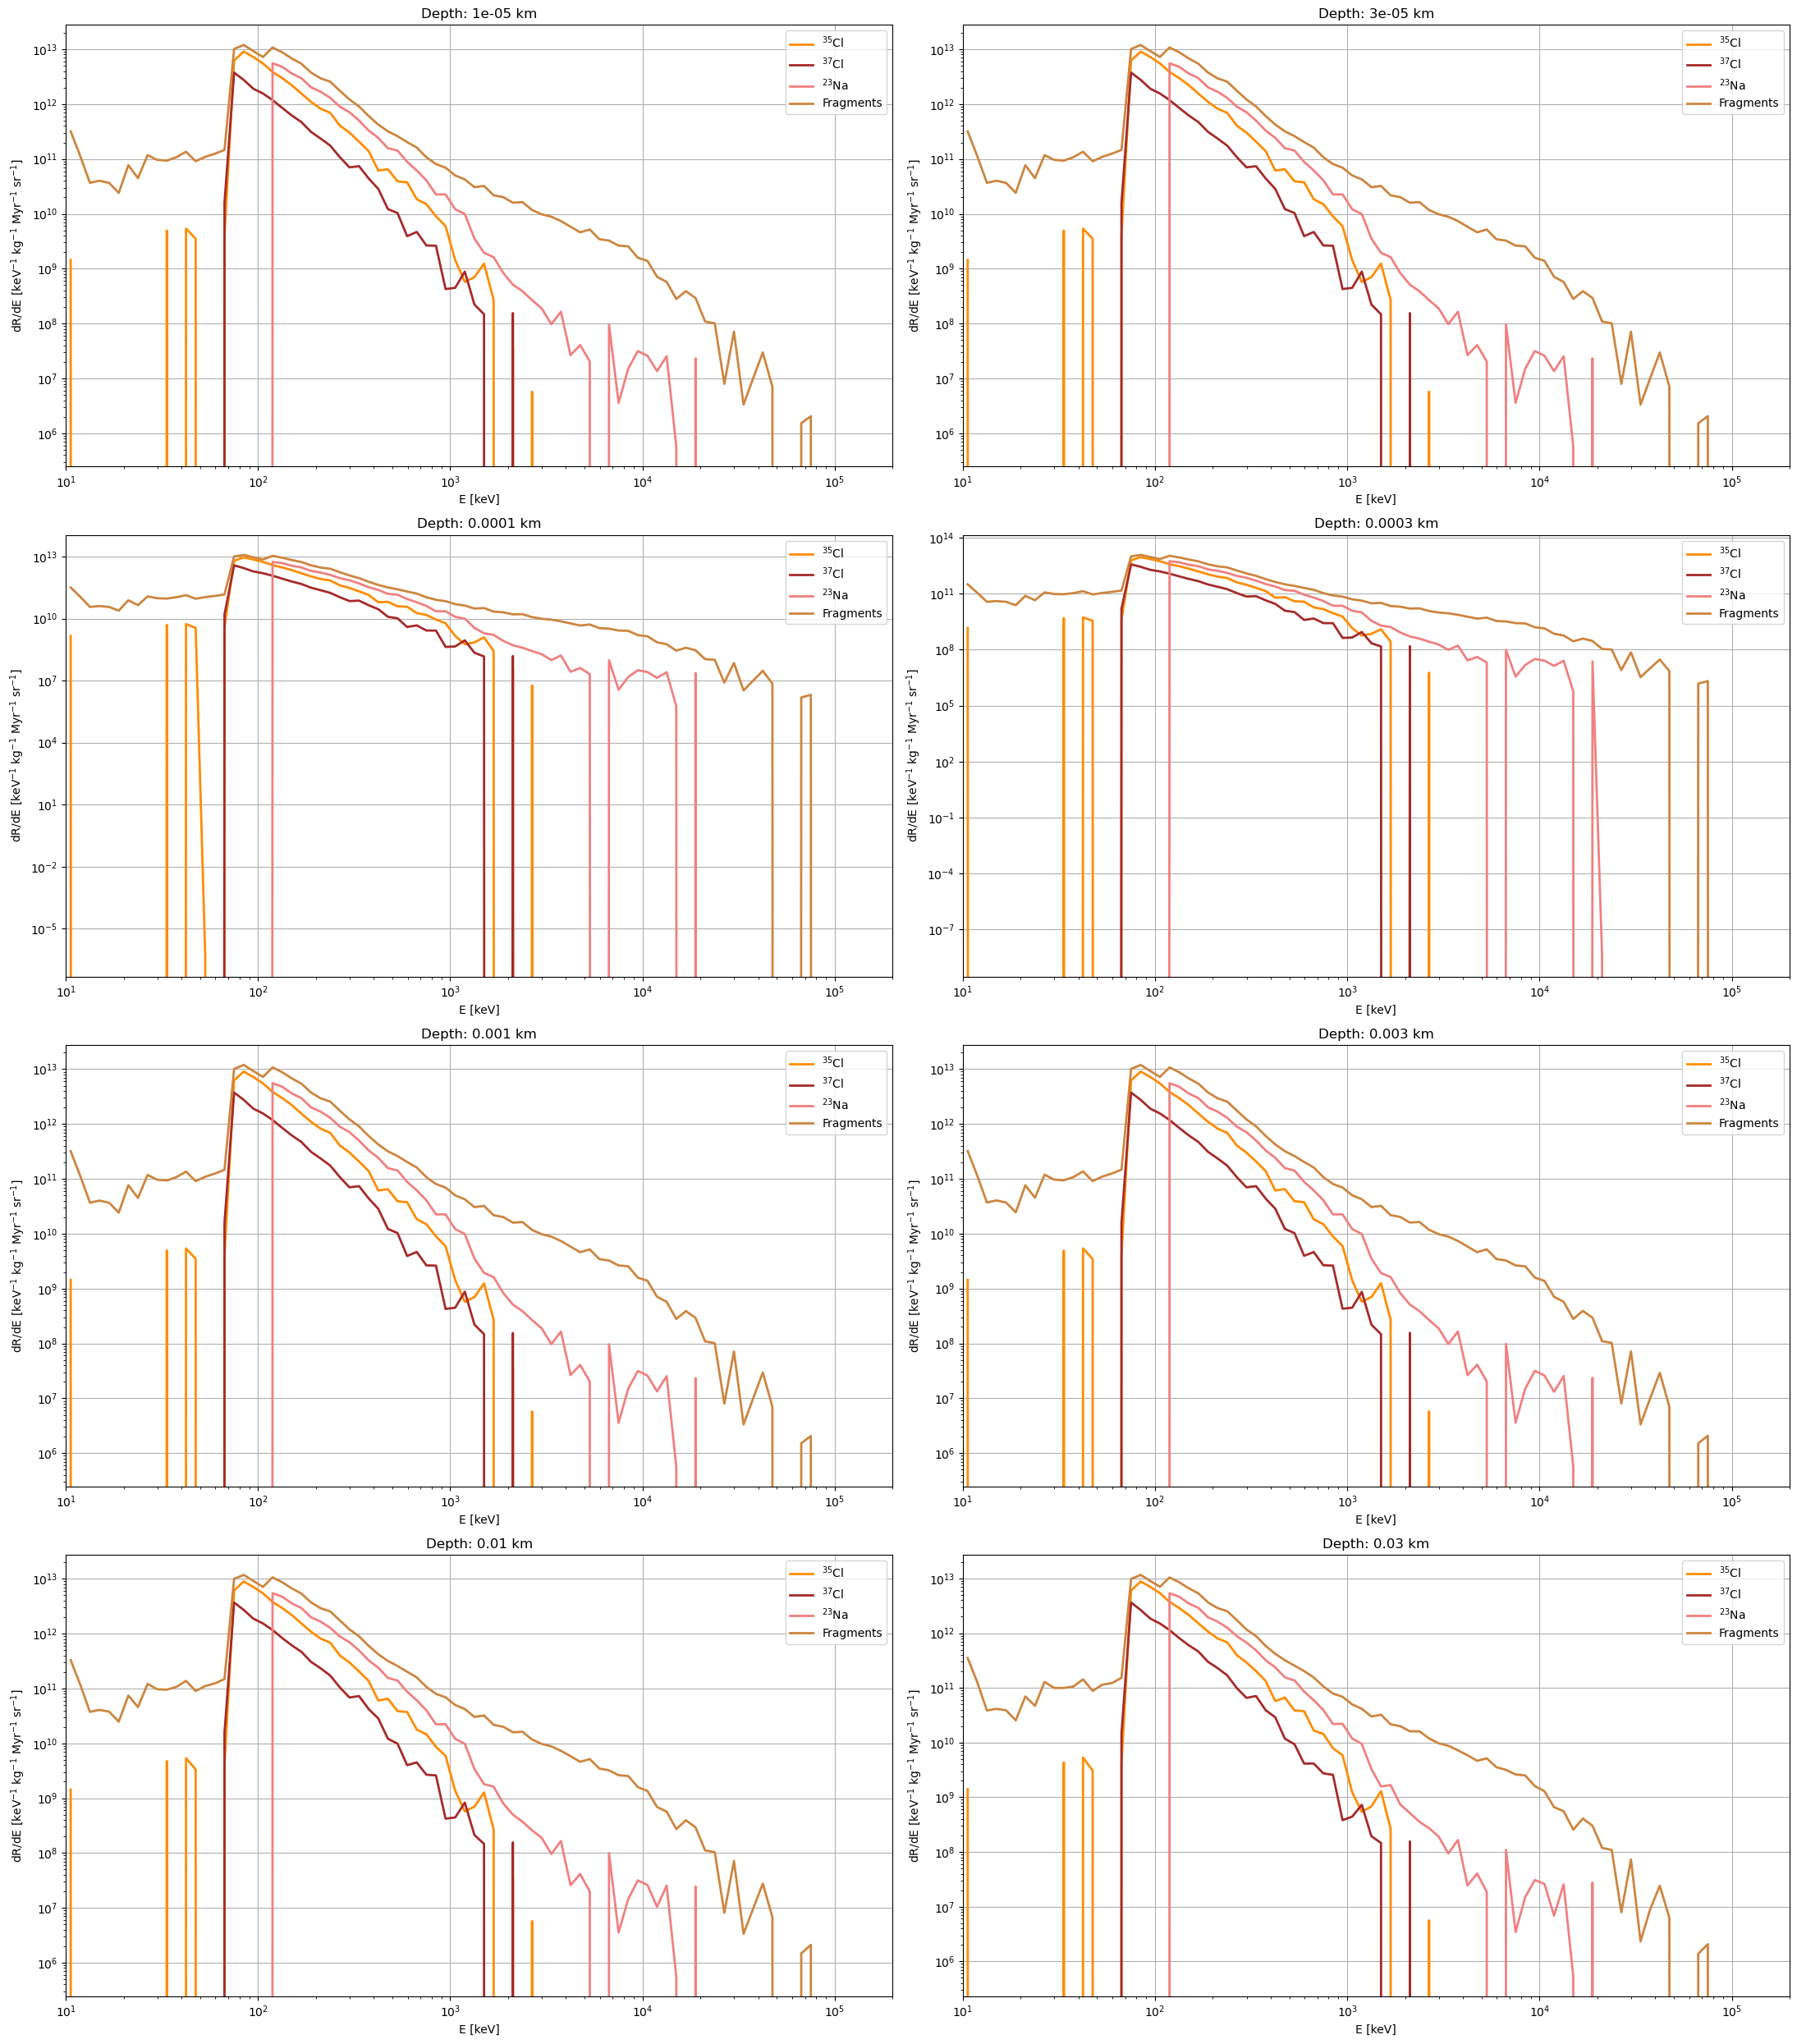

In [9]:
x_data, y_data = np.loadtxt('paleopy/Data/Halite_muon_recoil_Resconi.dat', usecols=(0, 1), unpack=True)
# Calcolo differenziale del flusso
y_data = y_data[:-1] / np.diff(x_data)
x_data = x_data[:-1]

# Crea una funzione di flusso "base" (senza attenuazione)
base_flux_func = log_interp1d(x_data, 1e-4 * y_data)

# Prepara la figura (8 subplot in 4 righe x 2 colonne)
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(22, 25))
axes = axes.flatten()  # per iterare su un solo array

for i, depth in enumerate(depths):
    # 2) Clona la funzione base in una listfunc di 1 elemento (se serve listfunc per Integration)
    listfunc = [base_flux_func]
    
    # Applica l’attenuazione alla funzione, per la profondità corrente
    xx = np.logspace(-2, 3, 101)
    ee = par(depth) * (xx + 510) - 510
    yy = listfunc[0](ee) * par(depth)
    # Sovrascrivi la listfunc con la versione attenuata
    listfunc[0] = log_interp1d(xx, yy)

    # 3) Integra i flussi nel tempo
    Num = Integration(listfunc, arr_time, tot_time)
    weight = Num / 1e4  

    
    n = 101
    Er = np.logspace(-2, 3, n)    # MeV da 1e-2 a 1e3
    Er_width = np.diff(Er)
    Er_mid = Er[:-1] + Er_width/2

    length = 1000    # cm
    rho    = 2.16e-3 # kg/cm^3

    # 5) Conta i nuclei prodotti (Cl35, Cl37, Na23, frammenti...)
    Conta = Count(weight, Er)  # restituisce [Cl35, Cl37, Na23, Frag, NomiNuclei]

    # Somma dei frammenti “Frag”
    Frag = np.zeros(len(Er_mid))
    for k in range(len(Conta[4])):       # scorre tutti i 'nomi' dei nuclei in Conta[4]
        for j_bin in range(len(Er_mid)): # scorre i bin energetici
            Frag[j_bin] += Conta[3][k][j_bin]

    # Interpola i conteggi normalizzati per ciascun nucleo (Cl35, Cl37, Na23)
    F35 = interp1d(Er_mid, Conta[0] / Er_width, fill_value='extrapolate')
    F37 = interp1d(Er_mid, Conta[1] / Er_width, fill_value='extrapolate')
    F23 = interp1d(Er_mid, Conta[2] / Er_width, fill_value='extrapolate')

   
    ax = axes[i]
    ax.loglog(Er_mid * 1e3, F35(Er_mid) * 1e-3 / (length * rho), label="$^{35}$Cl", linewidth=2, color='darkorange')
    ax.loglog(Er_mid * 1e3, F37(Er_mid) * 1e-3 / (length * rho), label="$^{37}$Cl", linewidth=2, color='brown')
    ax.loglog(Er_mid * 1e3, F23(Er_mid) * 1e-3 / (length * rho), label="$^{23}$Na", linewidth=2, color='lightcoral')
    ax.loglog(Er_mid * 1e3, Frag * 1e-3 / Er_width / (length * rho), label="Fragments", linewidth=2, color='peru')

    ax.set_xlabel("E [keV]")
    ax.set_ylabel("dR/dE [keV$^{-1}$ kg$^{-1}$ Myr$^{-1}$ sr$^{-1}$]")
    ax.set_xlim(1e1, 2e5)
    ax.grid(True)
    ax.legend()

    ax.set_title(f"Depth: {depth:.3g} km")

    # 7) Salva i risultati su file
    Stampa('overburden_Resconi', str(depth), Conta, Er)

plt.tight_layout()
plt.show()


## dRdx

 DMutils.py: Loading neutrino flux for the first time...
Loading neutrino fluxes for...
    DSNB
    atm
    hep
    8B
    15O
    17F
    pep
    13N
    pp
    7Be-384
    7Be-861
...done.


/home/fefe/Thesis/all_you_need/geant/Halite.py:42: RuntimeWarning: divide by zero encountered in log10
  logy = np.log10(yy)
/home/fefe/Thesis/all_you_need/geant/Halite.py:42: RuntimeWarning: divide by zero encountered in log10
  logy = np.log10(yy)
/home/fefe/Thesis/all_you_need/geant/Halite.py:42: RuntimeWarning: divide by zero encountered in log10
  logy = np.log10(yy)
/home/fefe/Thesis/all_you_need/geant/Halite.py:42: RuntimeWarning: divide by zero encountered in log10
  logy = np.log10(yy)
/home/fefe/Thesis/all_you_need/geant/Halite.py:42: RuntimeWarning: divide by zero encountered in log10
  logy = np.log10(yy)
/home/fefe/Thesis/all_you_need/geant/Halite.py:42: RuntimeWarning: divide by zero encountered in log10
  logy = np.log10(yy)
/home/fefe/Thesis/all_you_need/geant/Halite.py:42: RuntimeWarning: divide by zero encountered in log10
  logy = np.log10(yy)
/home/fefe/Thesis/all_you_need/geant/Halite.py:42: RuntimeWarning: divide by zero encountered in log10
  logy = np.log10(yy)


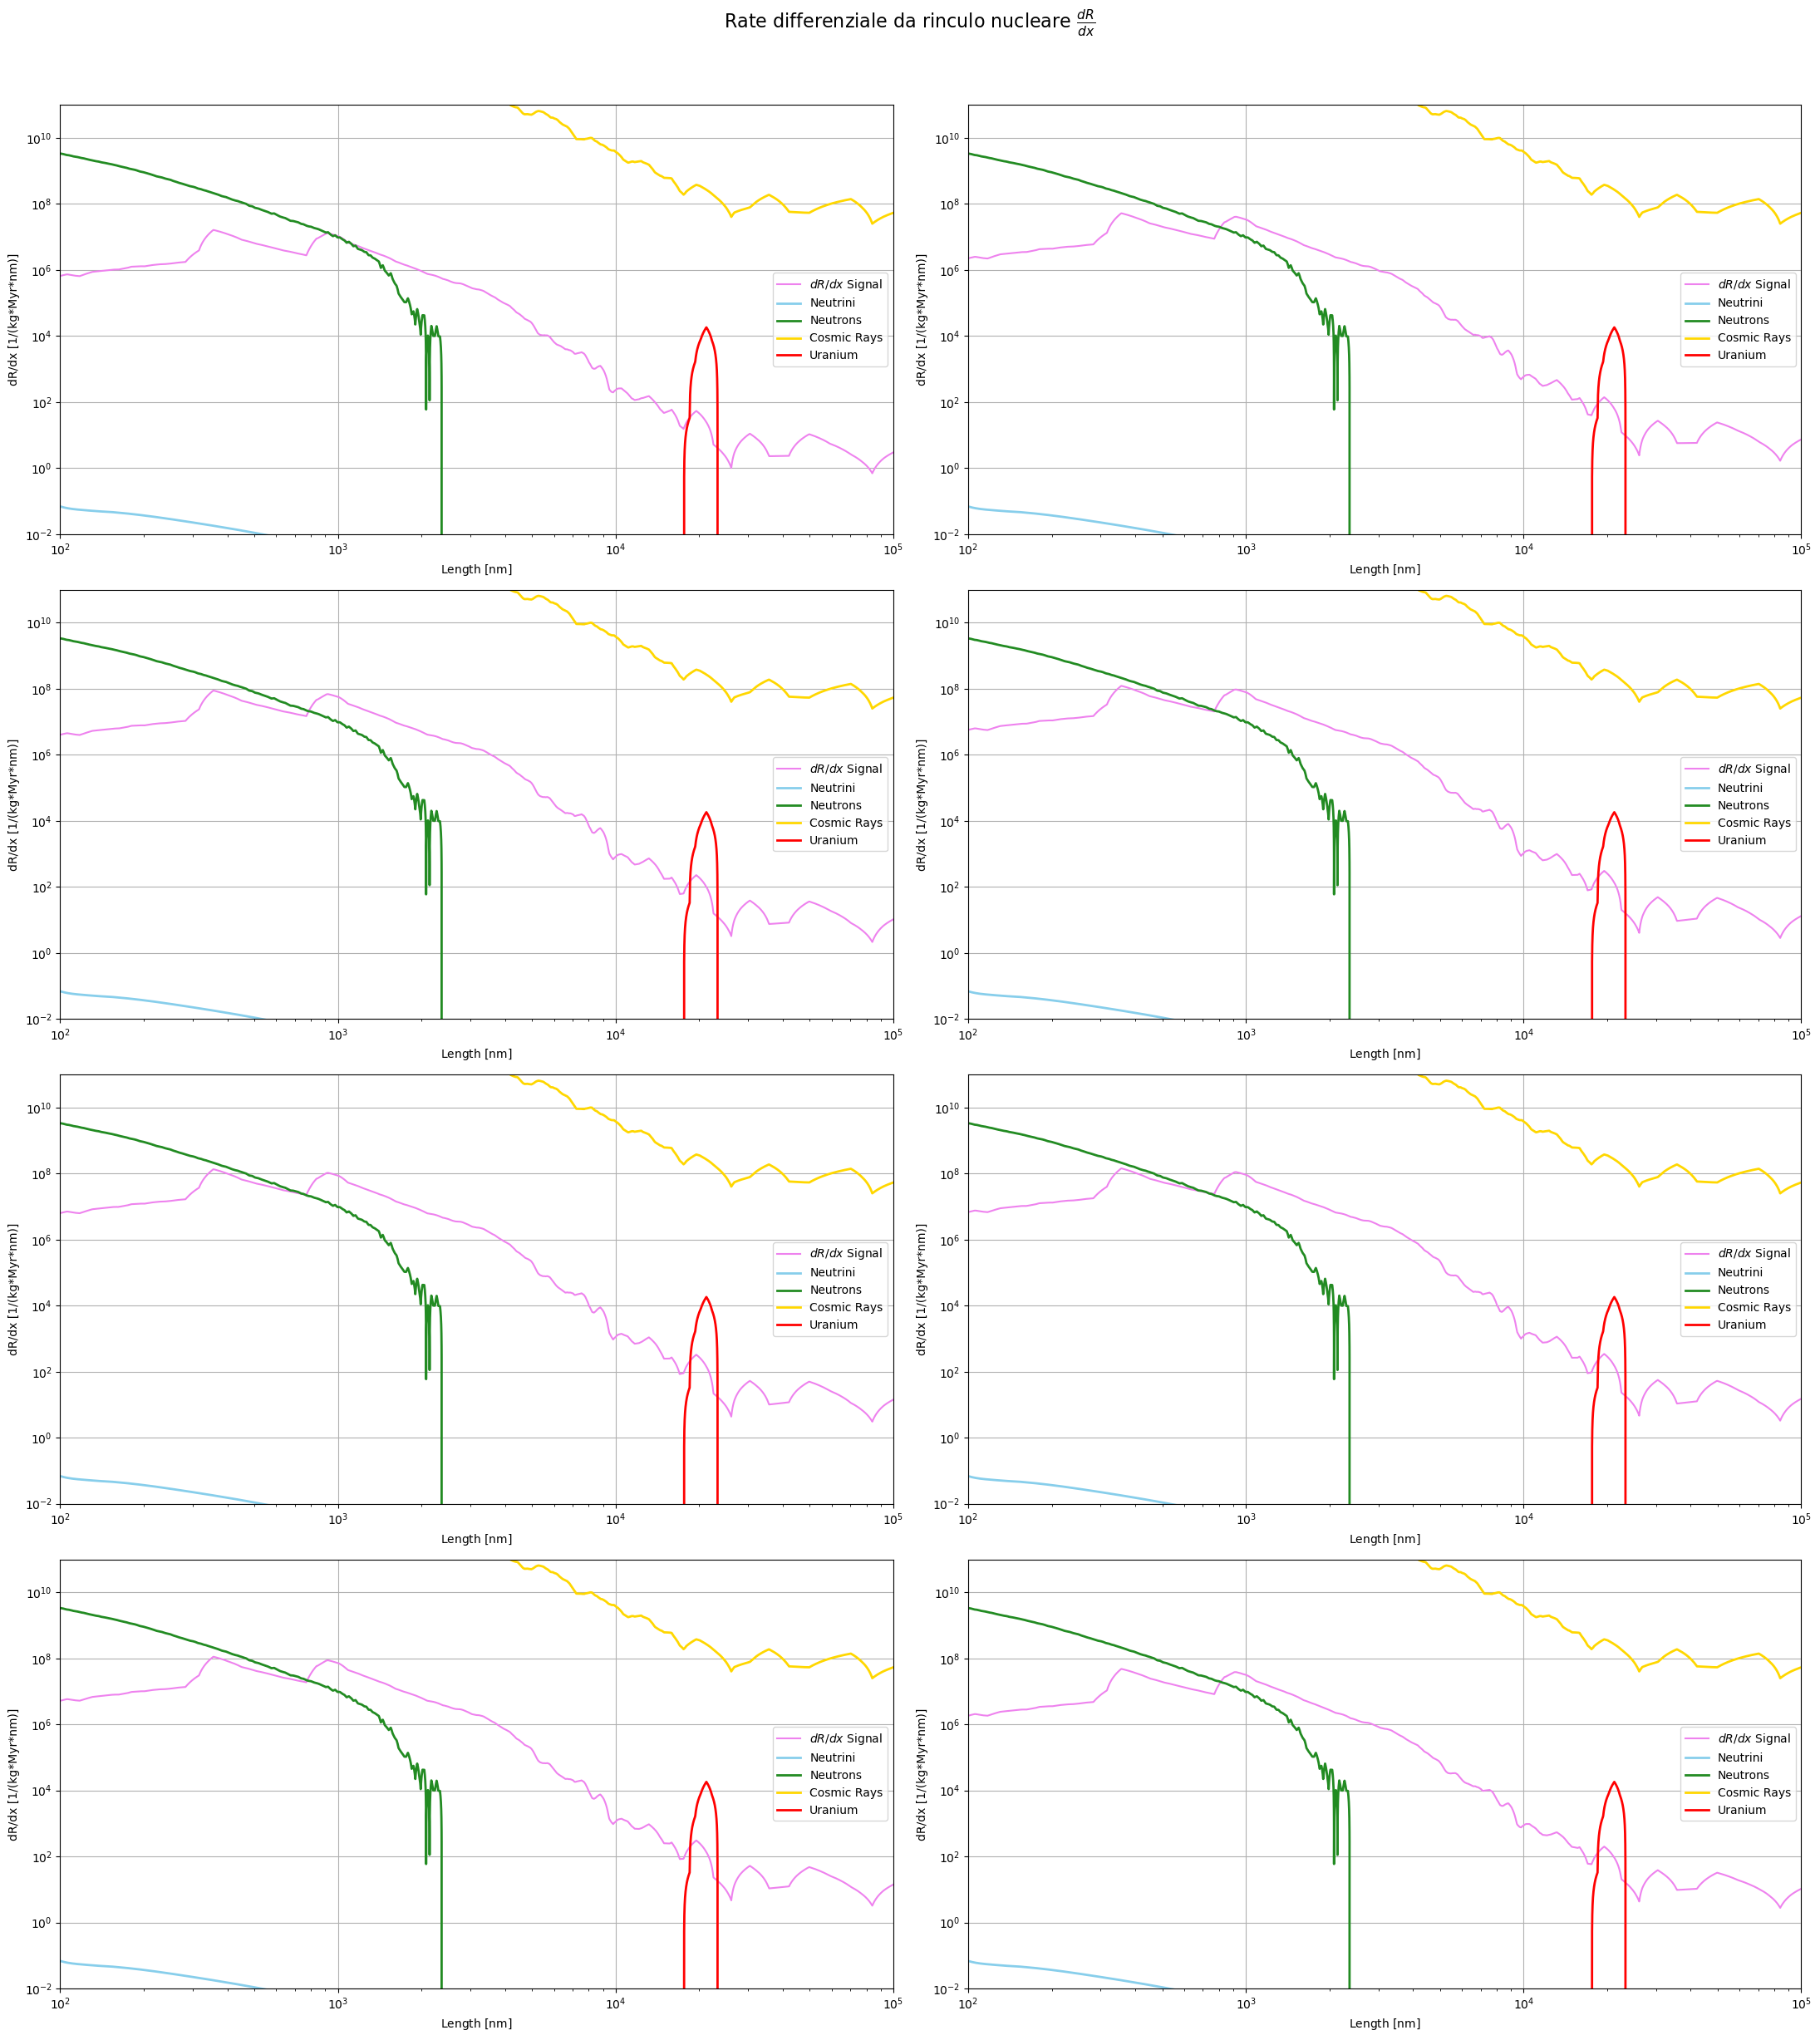

In [6]:
# Parametri iniziali
Er = np.logspace(-2, 3, 101)  # Energia in MeV

# Crea la figura e i subplot 4x2
fig, axs = plt.subplots(4, 2, figsize=(22, 25))
fig.suptitle("Rate differenziale da rinculo nucleare $\\frac{{dR}}{{dx}}$", fontsize=16)

for idx, n in enumerate(name):
    
    # Seleziona il subplot corrente
    if idx < axs.size:
        ax = axs.flat[idx]  # Scorri attraverso i subplot in ordine lineare

        # Aggiungo il calcolo di dR/dx (z_bins in nm)
        z_bins = np.linspace(0, 100000, 100000)
        #correzione numero di z_bins
        zz_centre = z_bins[:-1] +  np.diff(z_bins)/2.

        y_valuesSig = halite.dRdx_muons_fefe(z_bins,"20pc", "_overburden_"+ n)

        # Altri contributi
        y_nu        = halite.dRdx_nu(z_bins)
        y_neutrons  = halite.dRdx_neutrons(z_bins)
        y_cosmicrays = halite.dRdx_muons_fefe(z_bins, "overburden_Resconi", str(depth))
        y_cosmicrays_interp = log_interp1d(zz_centre, y_cosmicrays)
        
        
        #adding Uranium tracks
        data_U = np.loadtxt("../Fission/Uranium_counts.txt", comments="#")
        i_index = data_U[:,0]   # 0..(n_bins-2)
        count_U = data_U[:,1]   # lunghezza 199

        U_x_min = 1
        U_x_max = 5
        U_n_bins = 200
        U_length = np.logspace(U_x_min, U_x_max, U_n_bins) 
        length_centers = 0.5*(U_length[:-1] + U_length[1:])
        bin_widths = U_length[1:] - U_length[:-1]

        Na  = 6.022e23
        tau = 6.45e3
        factor = 1e-5*(5.4e-7)*((1.2e-6)*Na*1e3/(238))/tau
        
        y_U = count_U / bin_widths
        f_U = interp1d(length_centers, y_U, bounds_error=False, fill_value=0.0)
        yU_interp = f_U(zz_centre)

        # Plot
        ax.loglog(zz_centre, y_valuesSig, label='$dR/dx$ Signal', color='violet')

        # Valuta tu se serve la stessa scala:
        ax.loglog(zz_centre, y_nu, label='Neutrini', linewidth=2, color='skyblue')
        ax.loglog(zz_centre, y_neutrons, label='Neutrons', linewidth=2, color='forestgreen')
        ax.loglog(zz_centre, y_cosmicrays, label='Cosmic Rays', linewidth=2, color='gold') #divido per il tempo totale?
        ax.loglog(zz_centre, factor*yU_interp, label='Uranium', linewidth=2, color='red')


        ax.set_xlabel("Length [$\\mathrm{nm}$]")
        ax.set_ylabel("dR/dx [1/(kg*Myr*nm)]")
        ax.set_xlim(1e2, 1e5)
        ax.set_ylim(1e-2, 1e11)
        ax.legend()
        ax.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


## Integration

In [10]:
def integrate_in_bins(x, y, x_bins, mass, tot_time):
    """
    x: array 1D con i punti su cui è definita la curva (es. zz_centre).
    y: array 1D corrispondente, con dR/dx(x).
    x_bins: bordi dei bin, ad es. np.logspace(3,5,20).

    Restituisce un array con len(x_bins)-1 valori, 
    ognuno corrispondente all'integrale di y in [x_i, x_{i+1}].
    """
    counts = np.zeros(len(x_bins) - 1)
    for i in range(len(counts)):
        # maschera per i punti x dentro il bin
        mask = (x >= x_bins[i]) & (x < x_bins[i+1])
        if np.any(mask):
            # Esempio di integrazione numerica con trapz
            counts[i] = np.trapz(y[mask], x[mask])
    return counts*mass*tot_time


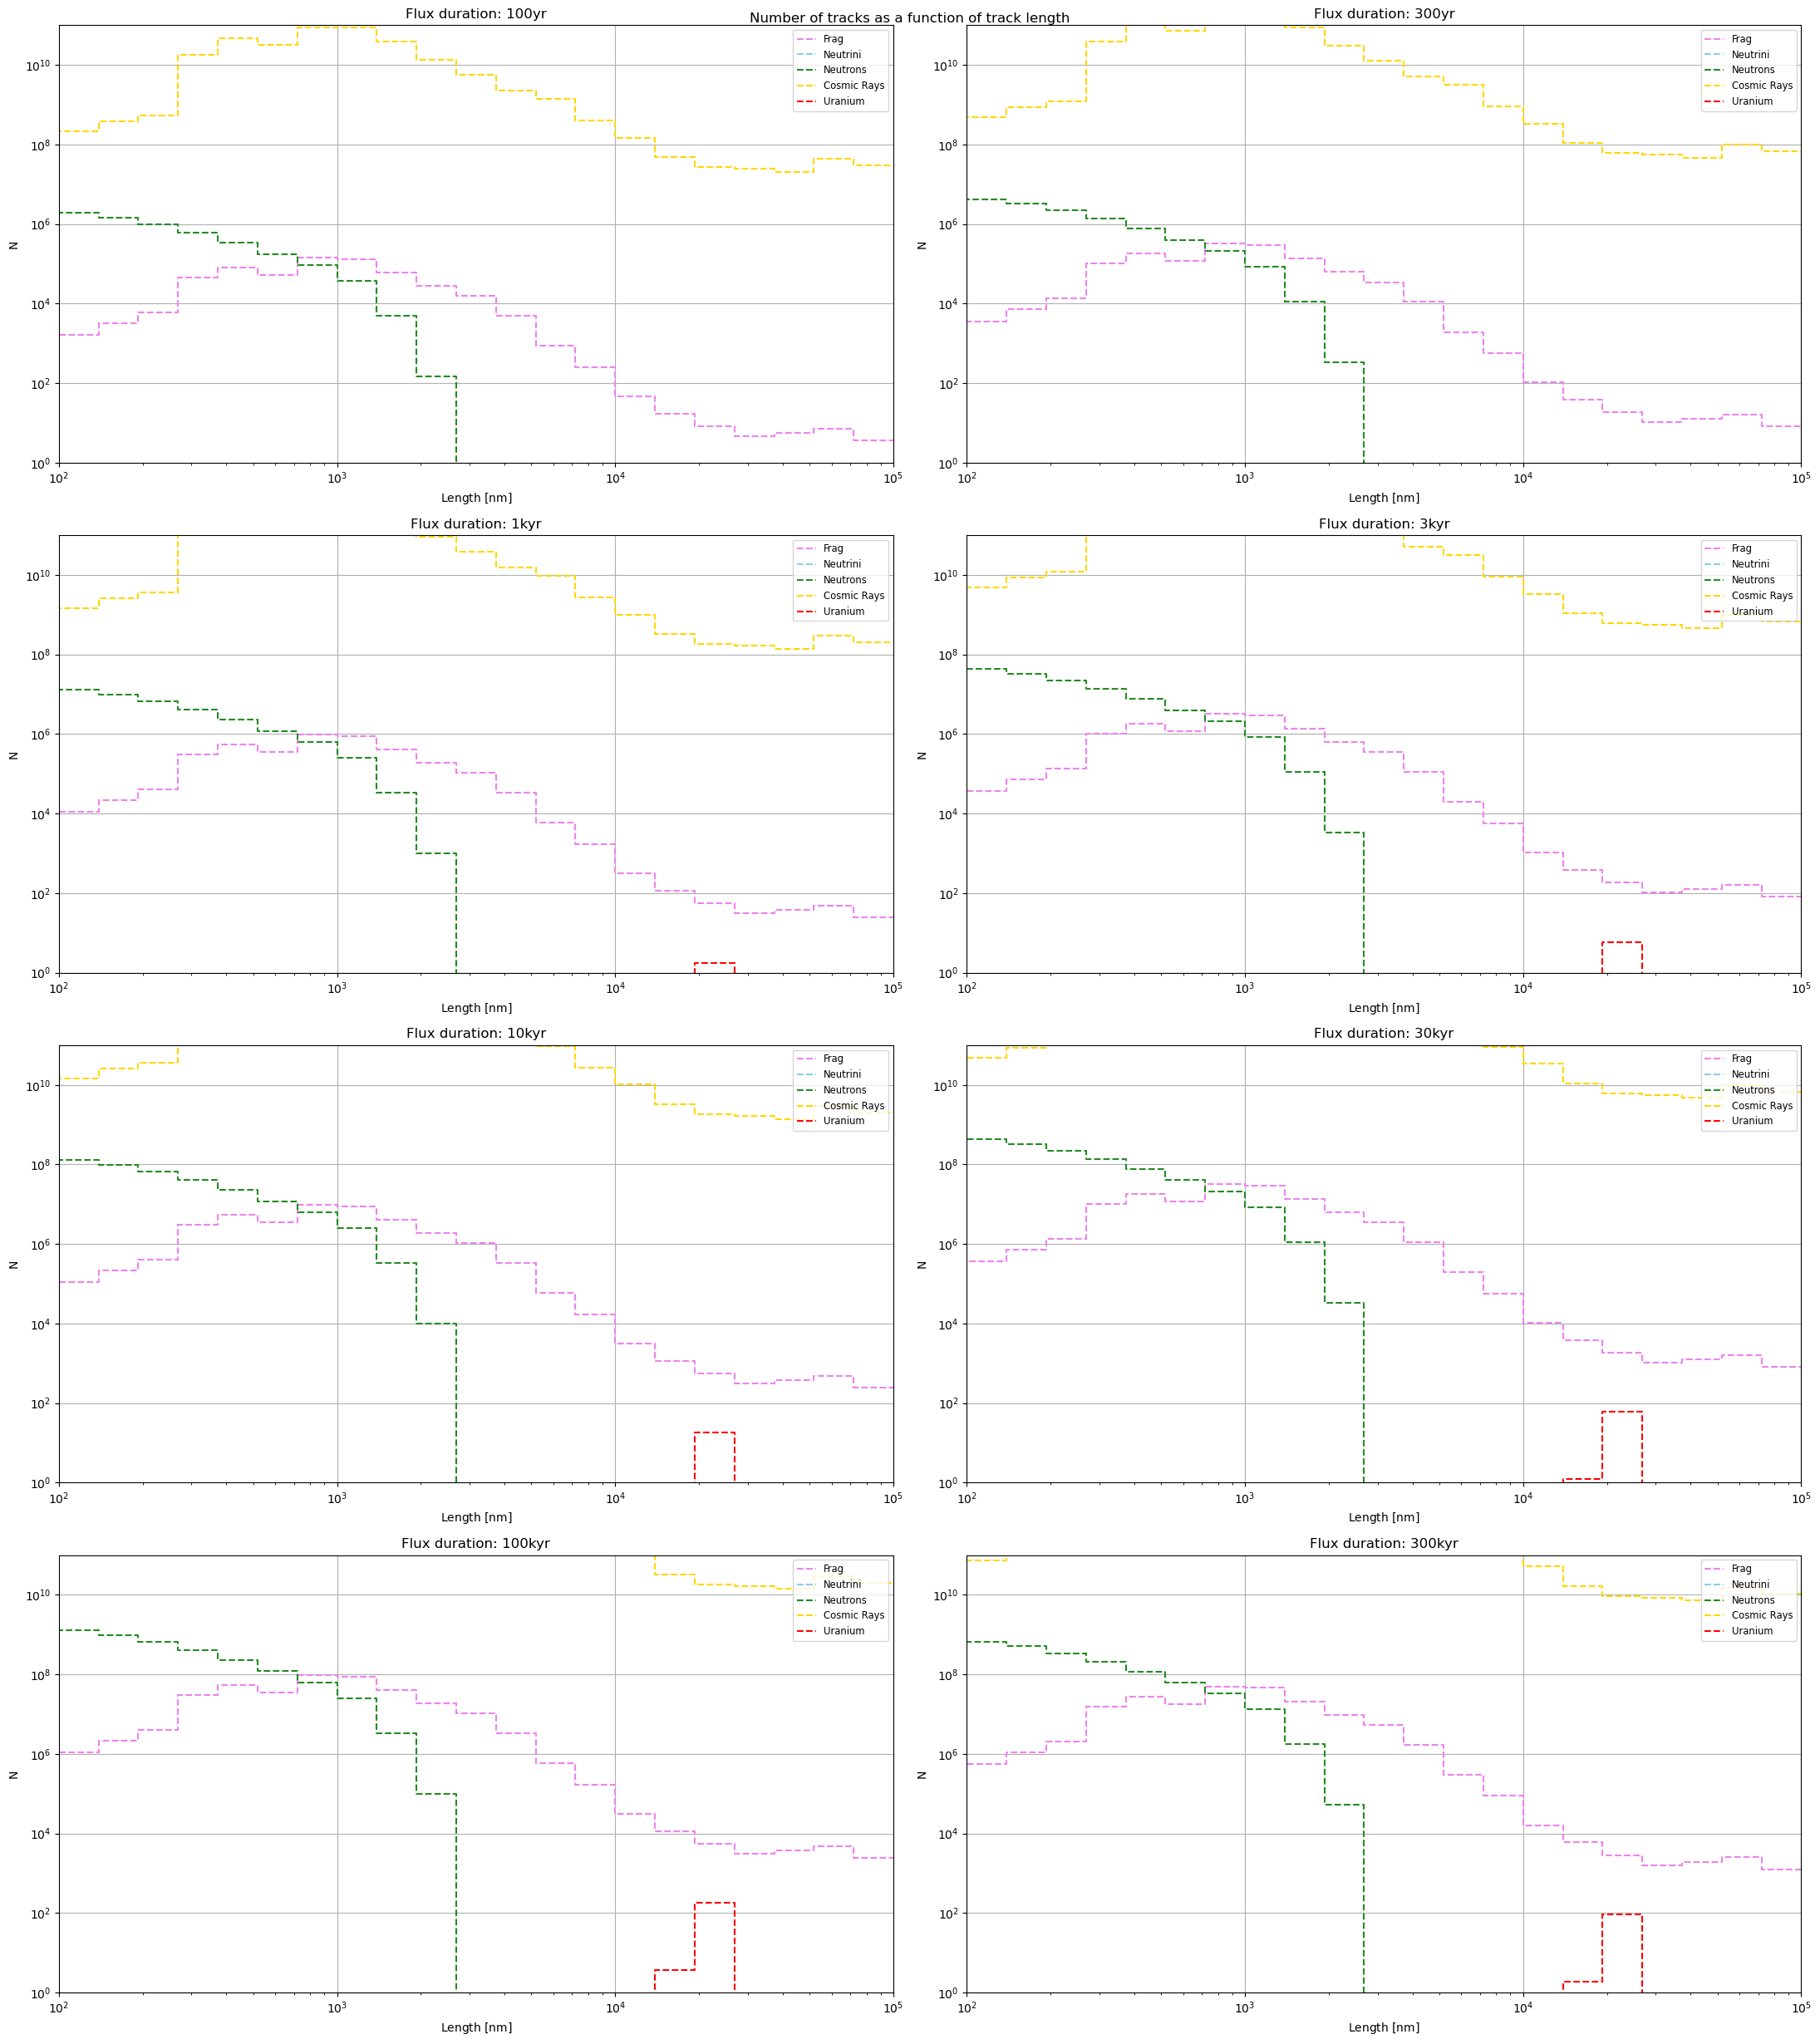

In [11]:
mass=0.1 #in kg

fig, axs = plt.subplots(4, 2, figsize=(22, 25))
fig.suptitle("Number of tracks as a function of track length")

for idx, n in enumerate(name):
    if idx < axs.size:
        ax = axs.flat[idx]  # Scorri attraverso i subplot in ordine lineare

    # Definiamo i bin su x (lunghezza) e calcoliamo dR/dx
    z_bins = np.linspace(0, 100000, 100000)
    zz_centre = z_bins[:-1] + np.diff(z_bins)/2.

    # Scelta dei bin di lunghezza (in nm), da 1e-2 a 1e5 su scala log:
    i_bins = np.logspace(-2, 5, 50)  # 20 bin => 21 edges

    # Integra y_values nei bin:
    counts_Signal = integrate_in_bins(zz_centre, y_valuesSig, i_bins, mass, arr_time[idx])
    counts_nu = integrate_in_bins(zz_centre, y_nu, i_bins, mass, arr_time[idx])
    counts_neutrons = integrate_in_bins(zz_centre, y_neutrons, i_bins, mass, arr_time[idx])
    counts_cosmics = integrate_in_bins(zz_centre, y_cosmicrays, i_bins, mass, arr_time[idx])
    counts_U = integrate_in_bins(zz_centre, yU_interp, i_bins, mass, arr_time[idx])

    #signal plot
    ax.step(i_bins, np.r_[counts_Signal, counts_Signal[-1]], where='post', color='violet', linestyle='--', label='Frag')

    #background plot
    ax.step(i_bins, np.r_[counts_nu, counts_nu[-1]], where='post', color='skyblue', linestyle='--', label='Neutrini') #non moltiplico questi background per factor perchè lo sono già le loro y
    ax.step(i_bins, np.r_[counts_neutrons, counts_neutrons[-1]], where='post', color='forestgreen', linestyle='--', label='Neutrons')
    ax.step(i_bins, np.r_[counts_cosmics, counts_cosmics[-1]], where='post', color='gold', linestyle='--', label='Cosmic Rays')
    ax.step(i_bins, np.r_[counts_U, counts_U[-1]], where='post', color='red', linestyle='--', label='Uranium')

    ax.set_xlabel("Length [$\\mathrm{nm}$]")
    ax.set_ylabel("N")
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(1e2, 1e5)
    ax.set_ylim(1, 1e11)
    ax.legend(loc="upper right", fontsize="small")
    ax.grid(True)
    ax.set_title("Flux duration: " + n)

plt.tight_layout()
plt.show()